# Q1.

## Barker’s method and the two-coin algorithm

Barker introduced a new acceptance probability 
$$
    \alpha_B (x,y) = \frac{\pi(y)q(y,x)}{\pi(y)q(y,x) + \pi(x)q(x,y)}
$$

If for some reason we cannot use MH, Barker's method can be a way out as it is proven to be statistically less efficient, but has an upper bound for the variance in terms of the MH variance.

$$
var_\pi (P_{MH}, h) \le var_\pi (P_{B}, h) \le 2 var_\pi (P_{MH}, h) + var_\pi (h)
$$

h being an estimator function.

But, when the posterior ($ \tilde\pi $ or $\pi$)  is such that their values cannot be determined precisely (when the likelihood or priors are not known to us), we cannot calculate these acceptance probabilities anymore. 

In such cases, instead of directly calculating the acceptance probability, we can sample it as a bernoulli event as discussed in the paper. A Bernoulli Factory is the algorithm which generates a bernoulli event using some input bernoulli event (by some transformation function).

A bound $\pi(x)q(x,y) \le c_x$ is obtained so that $\pi(x)q(x,y) = c_xp_x$ where $p_x$ is a probability, then to find the probability $\alpha_b$ we evaluate $\frac{c_xp_x}{c_xp_x + c_yp_y}$

The algorithm used for doing so is already proved to work in assignment 2, Q1, which is known as the two-coin algorithm.

## Portkey Barker’s method

In following the two-coin algorithm, the algorithm gets stuck in a long loop if the value of $p_x$ is small.

Hence, the portkey acceptance probability was introduced.
$$
    \alpha_P (x,y) = \frac{\pi(y)q(y,x)}{\pi(y)q(y,x) + \pi(x)q(x,y) + d(x, y)}
$$

Here d(x,y) is symmetric, hence this acceptance probability yields a $\pi$- invariant markov chain.

The particular d chosen for this algorithm is
$$
d(x, y) = \frac{1-\beta}{\beta} (c_x+c_y)
$$
where $\beta \in (0,1]$ and $\beta = 1$ gives the Barker's acceptance probability.

Generally $\beta \approx 1$ to remain close to the Barker's algorithm.

Then we use portkey two-coin algorithm drawing values from Bern($\beta$) with the number of loops varying geometic

## Flipped portkey two-coin algorithm

This method is used to get a $\tilde c_x$ which is some lower bound for the product $\pi(x)q(x,y)$ for a target density where obtaining a lower bound is easier.

$\alpha_P$ is essesntially divided by $\pi(x)q(x,y)\pi(y)q(y,x)$ giving
$$
 \alpha_F (x,y) = \frac{(\pi(y)q(y,x))^{-1}}{(\pi(y)q(y,x))^{-1} + (\pi(x)q(x,y))^{-1} + d'(x, y)}
$$

The function $d'(x,y)$ uses the lower bounds on product $\pi(x)q(x,y)$ to obtain a value.
$$
    d'(x,y) = \frac{1-\beta}{\beta} \frac{(\tilde c_x+\tilde c_y)}{\tilde c_x\tilde p_x\tilde c_y\tilde p_y}
$$

A similar portkey two-coin algorithm drawing values from Bern($\beta$) called, flipped portkey two-coin algorithm.

NOTE: [This talk](https://www.youtube.com/watch?v=J8edbFTPCdA) helped me understand a lot and is referred here as well.

---

# Q2

In [2]:
using Distributions
using Random
using Plots
using BenchmarkTools
Random.seed!(42)

TaskLocalRNG()

In [15]:
function portkey(prop, curr, beta, pf, cprop, ccurr, k, a1, b1)
    x = NaN
    loops = 0
    C = cprop/(ccurr + cprop)
    S = 1

    while isnan(x)
        loops = loops + 1
        if beta != 1.0
            S = rand(Binomial(1, beta))
        end
        if S == 0
            x = curr
            return x, loops
        else
            C1 = rand(Binomial(1, C))
            if C1 == 1
                p1 = pf(prop, k, a1, b1)
                C2 = rand(Binomial(1, p1))
                if C2 == 1
                    x = prop
                    return x, loops
                end
            else
                p2 = pf(curr, k, a1, b1)
                C2 = rand(Binomial(1, p2))
                if C2 == 1
                    x = curr
                    return x, loops
                end
            end
        end
    end
end

portkey (generic function with 1 method)

In [16]:
function Cf(value, k)
    return k/(ℯ*value)
end

function Weibull(value, k, a)
    return (k/a) * (value/a)^(k-1) * exp(-(value/a)^k)
end

function Pf(value, k, a1, b1)
    x = Weibull(value, k, rand(Gamma(a1, b1)))
    return x/Cf(value, k)
end

Pf (generic function with 1 method)

In [21]:
function mcmc(N, beta, k, a1, b1)
    out = zeros(N)
    loops = zeros(N)
    out[1] = .1
    
    for i in 2:N
        prop = rand(Normal(out[i-1], sqrt(.001)))
        if prop < 0
            out[i] = out[i-1]
            continue
        end
        x_val, loops_val = portkey(prop, out[i-1], beta, Pf, Cf(prop, k), Cf(out[i-1], k), k, a1, b1)
        out[i] = x_val
        loops[i] = loops_val
    end
    
    return out, loops
end

mcmc (generic function with 1 method)

In [ ]:
barker_mcmc, barker_loops = mcmc(1000, 1, 10, 10, 100)

In [26]:
portkey_mcmc, portkey_loops = mcmc(1000, .99, 10, 10, 100);

In [32]:
random_mcmc, random_loops = mcmc(1000, .80, 10, 10, 100);

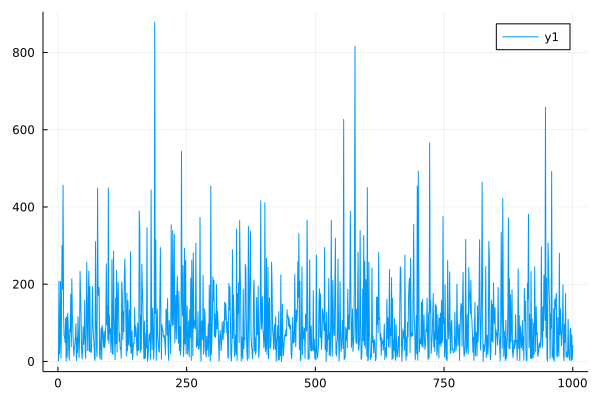

In [33]:
plot(portkey_loops)

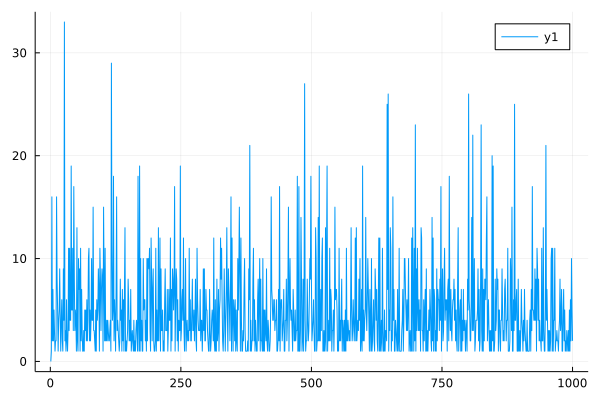

In [34]:
plot(random_loops)

In [35]:
random1_mcmc, random1_loops = mcmc(1000, .90, 10, 10, 100);

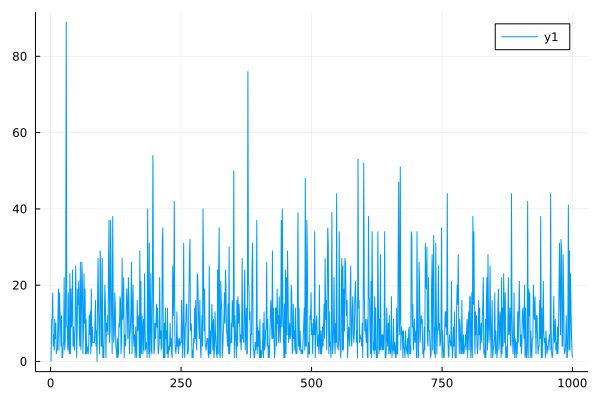

In [36]:
plot(random1_loops)

As the value of $\beta$ decreased, the number of loops for one output from the Bernoulli Factory decreased. 

Was unable to run the algorithm for Barker Method due to it being too slow on my machine, hence I was unable to make any comparision.

Referred to the implementation [here](https://github.com/dvats/portkey/blob/master/R/portkey.R)